# Plot Conditional Adjusted Predictions

This notebook shows how to use, and the capabilities, of the `plot_predictions` function. The `plot_predictions` function is a part of Bambi's sub-package `interpret` that features a set of tools used to interpret complex regression models that is inspired by the R package [marginaleffects](https://vincentarelbundock.github.io/marginaleffects/articles/predictions.html#conditional-adjusted-predictions-plot). 

## Interpreting Generalized Linear Models

The purpose of the _generalized linear model_ (GLM) is to unify the approaches needed to analyze data for which either: (1) the assumption of a linear relation between $x$ and $y$, or (2) the assumption of normal variation is not appropriate. GLMs are typically specified in three stages:
1. the linear predictor $\eta = X\beta$ where $X$ is an $n$ x $p$ matrix of explanatory variables.
2. the link function $g(\cdot)$ that relates the linear predictor to the mean of the outcome variable $\mu = g^{-1}(\eta) = g^{-1}(X\beta)$
3. the random component specifying the distribution of the outcome variable $y$ with mean $\mathbb{E}(y|X) = \mu$.

Based on these three specifications, the mean of the distribution of $y$, given $X$, is determined by $X\beta: \mathbb{E}(y|X) = g^{-1}(X\beta)$. 

GLMs are a broad family of models where the output $y$ is typically assumed to follow an exponential family distribution, e.g., Binomial, Poisson, Gamma, Exponential, and Normal. The job of the link function is to map the linear space of the model $X\beta$ onto the non-linear space of a parameter like $\mu$. Commonly used link function are the _logit_ and _log_ link. Also known as the _canonical_ link functions. This brief introduction to GLMs is not meant to be exhuastive, and another good starting point is the Bambi [Basic Building Blocks](https://bambinos.github.io/bambi/notebooks/how_bambi_works.html#Link-functions) example.

Due to the link function, there are typically three quantities of interest to interpret in a GLM:
1. the linear predictor $\eta$
2. the mean $\mu = g^{-1}(\eta)$
3. the response variable $Y \sim \mathcal{D}(\mu, \theta)$ where $\mu$ is the mean parameter and $\theta$ is (possibly) a vector that contains all the other "nuissance" parameters of the distribution.

As modelers, we are usually more interested in interpreting (2) and (3). However, $\mu$ is not always on the same scale of the response variable and can be more difficult to interpret. Rather, the response scale is a more interpretable scale. Additionally, it is often the case that modelers would like to analyze how a model parameter varies across a range of explanatory variable values. To achieve such an analysis, Bambi has taken inspiration from the R package marginaleffects, and implemented a `plot_predictions` function that plots the conditional adjusted predictions to aid in the interpretation of GLMs. Below, it is briefly discussed what are conditionally adjusted predictions, how they are computed, and ultimately how to use the `plot_predictions` function.

## Conditionally Adjusted Predictions

Adjusted predictions refers to the outcome predicted by a fitted model on a specified scale for a given combination of values of the predictor variables, such as their observed values, their means, or some user specified grid of values. The specification of the scale to make the predictions, the link or response scale, refers to the scale used to estimate the model. In normal linear regression, the link scale and the response scale are identical, and therefore, the adjusted prediction is expressed as the mean value of the response variable at the given values of the predictor variables. On the other hand, a logistic regression's link and response scale are not identical. An adjusted prediction on the link scale will be represented as the log-odds of a successful response given values of the predictor variables. Whereas an adjusted prediction on the response scale gives the probability that the response variable equals 1. The conditional part of conditionally adjusted predictions represents the specific predictor(s) and its values we would like to condition on when plotting predictions.

### Computing Adjusted Predictions

The objective of plotting conditional adjusted predictions is to visualize how a parameter of the (conditional) response distribution varies as a function of (some) explanatory variables. In `predictions`, there are three scenarios to compute conditional adjusted predictions:

1. user provided values 
2. a grid of equally spaced and central values
3. empirical distribution (original data used to fit the model)

In the case of (1) above, a dictionary is passed with the explanatory variables as keys, and the values to condition on are the values. With this dictionary, Bambi assembles all pairwise combinations (transitions) of the specified explanatory variables into a new "hypothetical" dataset. Covariates not existient in the dictionary are held at their mean or mode. 

In (2), a string or list is passed with the name(s) of the explanatory variable(s) to create a grid of equally spaced values. This is done by holding all other explanatory variables constant at some specified value, a _reference grid_, that may or may not correspond to actual observations in the dataset used to fit the model. By default, the `plot_predictions` function uses a grid of 200 equally spaced values between the minimum and maximum values of the specified explanatory variable as the reference grid.

Lastly, in (3), the original data used to fit the model is used to compute predictions. This is known as _unit level_ predictions.

Using the data, from scenario 1, 2, or 3, the `plot_predictions` function uses the fitted model to then compute the predictions. The `plot_predictions` function then uses these predictions to plot the model parameter as a function of (some) explanatory variable. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import bambi as bmb

warnings.simplefilter(action="ignore", category=FutureWarning)

## Gaussian Linear Model

For the first demonstration, we will use a Gaussian linear regression model with the `mtcars` dataset to better understand the `plot_predictions` function and its arguments. The `mtcars` dataset was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973--74 models). The following is a brief description of the variables in the dataset:

- mpg: Miles/(US) gallon
- cyl: Number of cylinders
- disp: Displacement (cu.in.)
- hp: Gross horsepower
- drat: Rear axle ratio
- wt: Weight (1000 lbs)
- qsec: 1/4 mile time
- vs: Engine (0 = V-shaped, 1 = straight)
- am: Transmission (0 = automatic, 1 = manual)
- gear: Number of forward gear

In [3]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)

# Define and fit the Bambi model
model = bmb.Model("mpg ~ 0 + hp * wt + cyl + gear", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, hp, wt, hp:wt, cyl, gear]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


We can print the Bambi model object to obtain the model components. Below, we see that the Gaussian linear model uses an identity link function that results in no transformation of the linear predictor to the mean of the outcome variable, and the distrbution of the likelihood is Gaussian.

### Default values

Now that we have fitted the model, we can visualize how a model parameter varies as a function of (some) interpolated covariate. For this example, we will visualize how the mean response `mpg` varies as a function of the covariate `hp`. 

The Bambi model, ArviZ inference data object (containing the posterior samples and the data used to fit the model), and a list or dictionary of covariates, in this example only `hp`, are passed to the `plot_predictions` function. The `plot_predictions` function then computes the conditional adjusted predictions for each `covariate` in the list or dictionary using the method described above. The `plot_predictions` function returns a `matplotlib` figure object that can be further customized.  

Default computed for main variable: hp
Default computed for unspecified variable: cyl, gear, wt


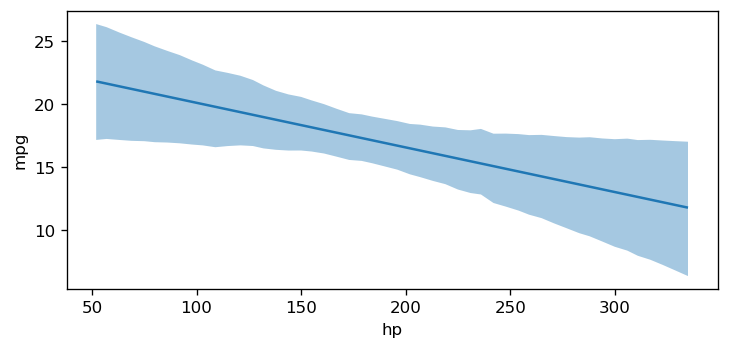

In [4]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, "hp", ax=ax);

Before we talk about the plot, you will notice that some messages have been logged to the console. By default `interpret` is _verbose_ and logs a message to the console if a default value is computed for covariates in `conditional`. This is useful because unless the documentation is read, it can be difficult to tell which covariates are having default values computed for. Thus, Bambi has a config file `bmb.config["INTERPRET_VERBOSE"]` where we can specify whether or not to log messages. By default, this is set to true. To turn off logging, set `bmb.config["INTERPRET_VERBOSE"] = False`. From here on, we will turn off logging.

The plot above shows that as `hp` increases, the mean `mpg` decreases. As stated above, this insight was obtained by creating the reference grid and then using the fitted model to compute the predicted values of the model parameter, in this example `mpg`, at each value of the reference grid.

By default, `plot_predictions` uses the highest density interval (HDI) of the posterior distribution to compute the credible interval of the conditional adjusted predictions. The HDI is a Bayesian analog to the frequentist confidence interval. The HDI is the shortest interval that contains a specified probability of the posterior distribution. By default, `plot_predictions` uses the 94% HDI.

`plot_predictions` uses the posterior distribution by default to visualize some mean outcome parameter . However, the posterior predictive distribution can also be plotted by specifying `pps=True` where `pps` stands for posterior predictive samples of the response variable.

In [5]:
bmb.config["INTERPRET_VERBOSE"] = False

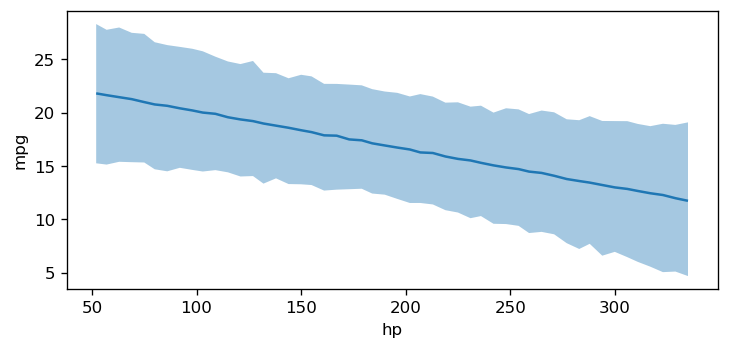

In [6]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, "hp", pps=True, ax=ax);

Here, we notice that the uncertainty in the conditional adjusted predictions is much larger than the uncertainty when `pps=False`. This is because the posterior predictive distribution accounts for the uncertainty in the model parameters and the uncertainty in the data. Whereas, the posterior distribution only accounts for the uncertainty in the model parameters.

Additionally, `predictions` can be called to obtain a summary dataframe of the data, mean predictions (estimate), and uncertainty interval. The covariate columns in this dataframe is used to create the plot.

In [20]:
summary_df = bmb.interpret.predictions(model, idata, "hp", pps=True)
summary_df.head(10)

,hp,cyl,gear,wt,estimate,lower_3.0%,upper_97.0%
0,52,high,A,3.21725,21.876109,15.133244,27.922724
1,57,high,A,3.21725,21.630976,15.038827,28.092181
2,63,high,A,3.21725,21.505488,15.294205,27.963085
3,69,high,A,3.21725,21.164276,15.054589,27.239663
4,75,high,A,3.21725,21.060886,14.989347,27.026034
5,80,high,A,3.21725,20.878214,15.214564,27.106655
6,86,high,A,3.21725,20.646827,14.528253,26.313486
7,92,high,A,3.21725,20.339827,14.846441,26.226122
8,98,high,A,3.21725,20.198725,14.666220,25.962922
9,103,high,A,3.21725,20.057896,14.665662,25.687646


`plot_predictions` allows up to three covariates to be plotted simultaneously where the first element in the list represents the main (x-axis) covariate, the second element the group (hue / color), and the third element the facet (panel). However, when plotting more than one covariate, it can be useful to pass specific `group` and `panel` arguments to aid in the interpretation of the plot. Therefore, `subplot_kwargs` allows the user to manipulate the plotting by passing a dictionary where the keys are `{"main": ..., "group": ..., "panel": ...}` and the values are the names of the covariates to be plotted. For example, passing two covariates `hp` and `wt` and specifying `subplot_kwargs={"main": "hp", "group": "wt", "panel": "wt"}`. 

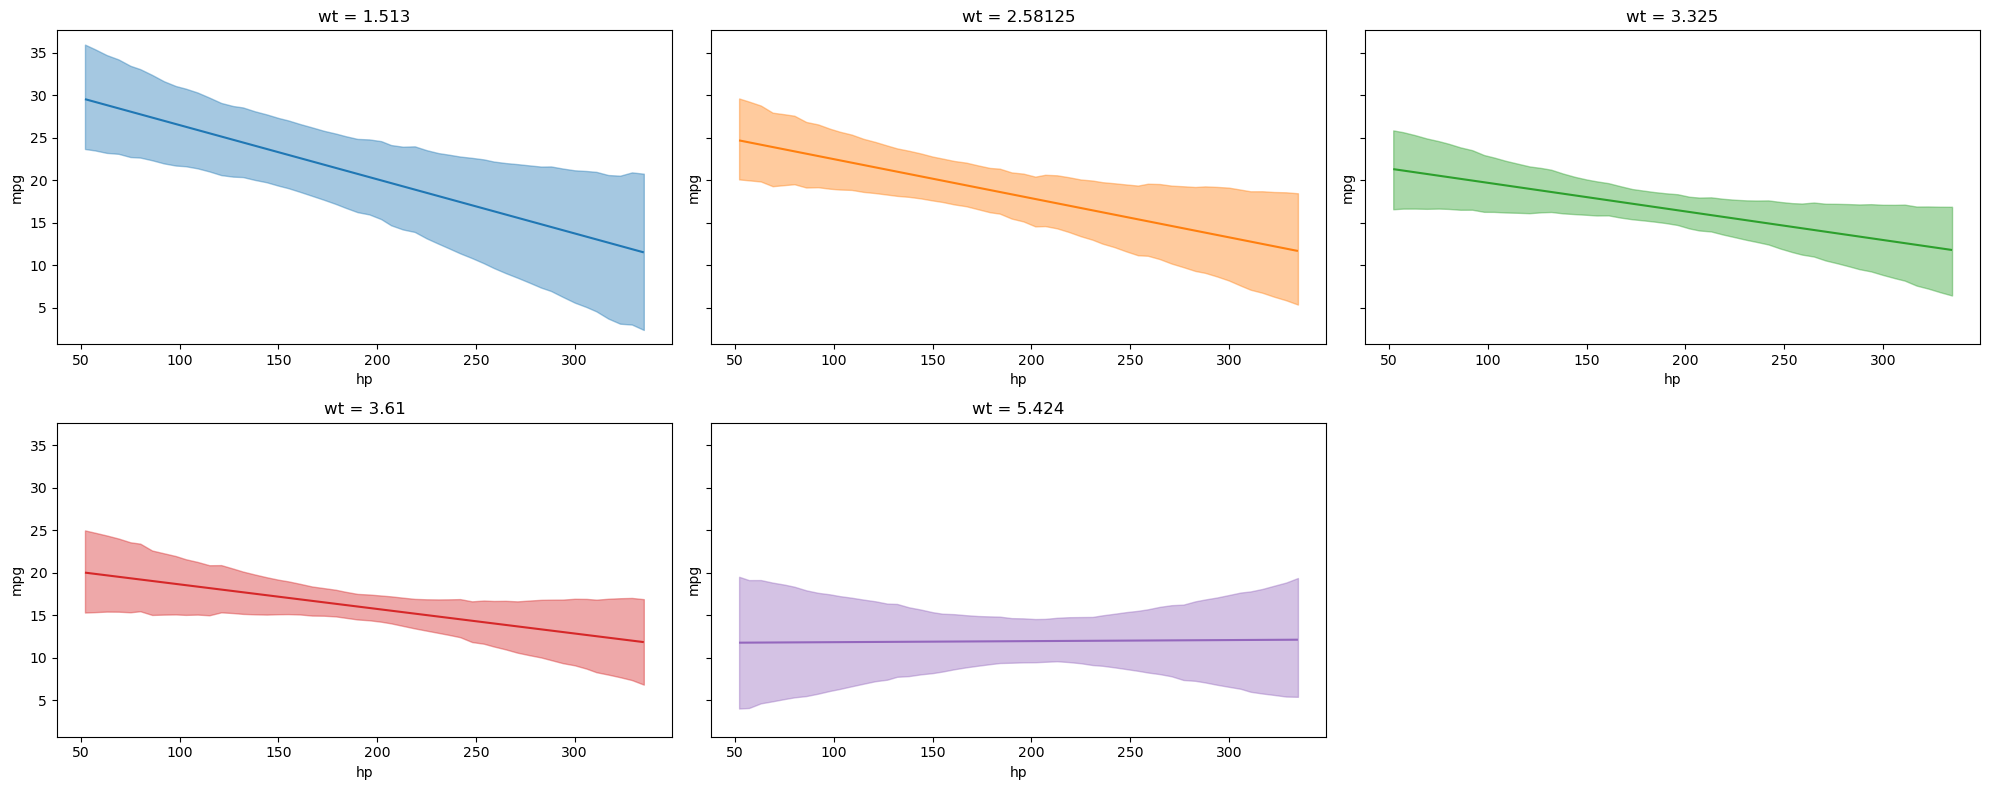

In [5]:
bmb.interpret.plot_predictions(
    model=model, 
    idata=idata, 
    conditional=["hp", "wt"],
    pps=False,
    legend=False,
    subplot_kwargs={"main": "hp", "group": "wt", "panel": "wt"},
    fig_kwargs={"figsize": (20, 8), "sharey": True}
)
plt.tight_layout();

Furthermore, categorical covariates can also be plotted. We plot the the mean `mpg` as a function of the two categorical covariates `gear` and `cyl` below. The `plot_predictions` function automatically plots the conditional adjusted predictions for each level of the categorical covariate. Furthermore, when passing a list of covariates into the `plot_predictions` function, the list will be converted into a dictionary object where the key is taken from ("horizontal", "color", "panel") and the values are the names of the variables. By default, the first element of the list is specified as the "horizontal" covariate, the second element of the list is specified as the "color" covariate, and the third element of the list is mapped to different plot panels.

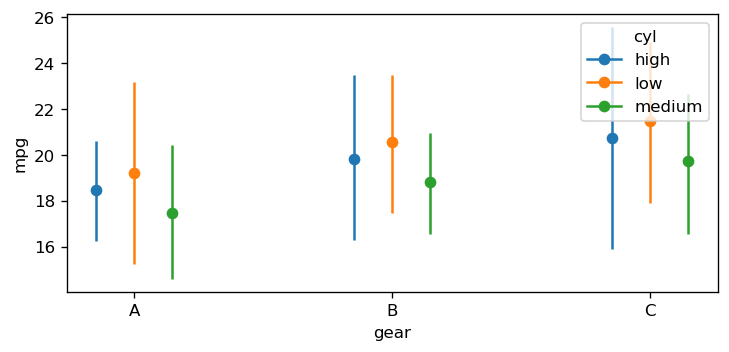

In [10]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, ["gear", "cyl"], ax=ax);

### User provided values

In the previous example, default values were computed to construct a reference grid to compute the conditional adjusted predictions. We can also pass our own values for the covariates into `conditional` using a dictionary where the key-value pairs are the covariate and value(s) of interest. For example, if we wanted to compute the predictions for `hp=100`,  `wt=[1.5, 3.5]`, and `cyl=["low", "medium", "high"]` we would pass the following dictionary in the code block below. As can be seen, several data types can be passed such as: `np.ndarray`, `list`, `int`, `float`, and `str`. 

Furthermore, Bambi by default, maps the order of the dict keys to the main, group, and panel of the matplotlib figure. Below, since `hp` is the first key, this is used for the x-axis, `wt` for the group (color), and `cyl` for the panel (facet).

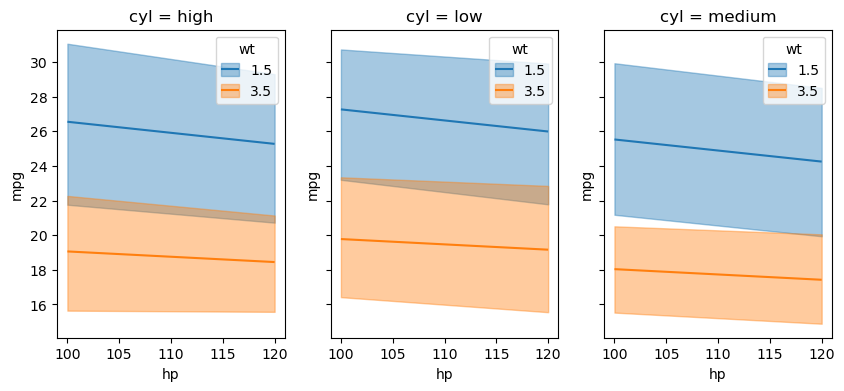

In [15]:
bmb.interpret.plot_predictions(
    model,
    idata,
    conditional={
        "hp": [100, 120],
        "wt": np.array([1.5, 3.5]),
        "cyl": ["low", "medium", "high"]
        },
   fig_kwargs={"figsize": (10, 4), "sharey": True}
);

Before the plot is described, lets see how the dictionary passed to `conditional` was used to create the dataset in order to compute predictions.

In [23]:
summary_df = bmb.interpret.predictions(
    model,
    idata,
    conditional={
        "hp": [100, 120],
        "wt": np.array([1.5, 3.5]),
        "cyl": ["low", "medium", "high"]
        },
)
summary_df.head(6)

,hp,wt,cyl,gear,estimate,lower_3.0%,upper_97.0%
0,100,1.5,low,A,27.270087,23.200397,30.732663
1,100,1.5,medium,A,25.531536,21.180258,29.935737
2,100,1.5,high,A,26.555116,21.760939,31.063823
3,100,3.5,low,A,19.776986,16.419739,23.345664
4,100,3.5,medium,A,18.038434,15.527548,20.512842
5,100,3.5,high,A,19.062014,15.640371,22.270361


When a dictionary is passed, that informs Bambi that the user wants to compute predictions on user provided values. Thus, a pairwise grid is constructed using the dictionary values. Otherwise, a dataframe of unequal array lengths cannot be constructed. Furthermore, since `gear` was not passed as a key, but was a term in the model, the default value of `A` was computed for it.

Given we now know that a pairwise grid was computed usiong the `conditional` dict, One interpretation of the plot above is that across all cylinder groups, a larger `wt` results in a lower mean `mpg`.

### Unit level predictions

In the previous example, user provided values were computed to construct a pairwise grid to compute the conditional adjusted predictions. It is also possible to compute predictions using the observed (empirical) data used to fit the model and then average over a specific or set of covariates to obtain average adjusted predictions. This is known as unit level predictions. To compute unit level predictions, do not pass any values to the `conditional` arg. and or specify `None` (the default).

In [7]:
summary_df = bmb.interpret.predictions(
    model,
    idata,
    conditional=None
)
summary_df.head()

,cyl,gear,hp,wt,estimate,lower_3.0%,upper_97.0%
0,medium,B,110,2.620,22.233424,20.051966,24.476544
1,medium,B,110,2.875,21.320402,19.196886,23.344765
2,low,B,93,2.320,25.901435,24.255648,27.558330
3,medium,A,110,3.215,18.751708,16.259737,21.293185
4,high,A,175,3.440,16.908354,15.261489,18.666662


In [9]:
# data used to fit the model
model.data[["cyl", "gear", "hp", "wt"]].head()

,cyl,gear,hp,wt
0,medium,B,110,2.620
1,medium,B,110,2.875
2,low,B,93,2.320
3,medium,A,110,3.215
4,high,A,175,3.440


Notice how the data in the summary dataframe and model data are the same.

#### Marginalizing over covariates

Since the empirical distrubution is used for computing predictions, the same number of rows ($32$) is returned as the data used to fit the model. To average over a covariate, use the `average_by` argument. If `True` is passed, then `predictions` averages over all covariates and a single estimate is returned. Else, if a single or list of covariates are passed, then `predictions` averages by the covariates passed.

In [26]:
summary_df = bmb.interpret.predictions(
    model,
    idata,
    conditional=None,
    average_by=True
)
summary_df

,estimate,lower_3.0%,upper_97.0%
0,20.060735,17.838142,22.28725


#### Average by subgroups

It is still possible to plot predictions when computing unit level predictions. However, now a covariate(s) must be passed to `average_by` to obtain average adjusted predictions by group. In the plot below, we obtain average predictions grouped by `gear` and `cyl`. 

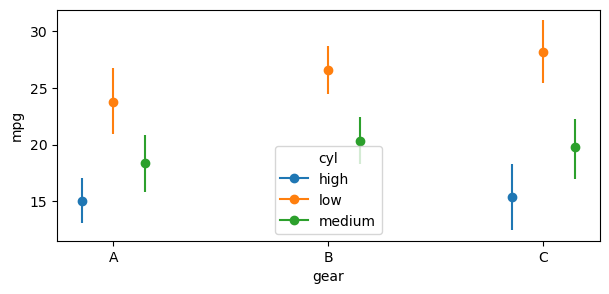

In [10]:
bmb.interpret.plot_predictions(
    model,
    idata,
    conditional=None,
    average_by=["gear", "cyl"],
    fig_kwargs={"figsize": (7, 3)},
);

## Negative Binomial Model

Lets move onto a model that uses a distribution that is a member of the exponential distribution family and utilizes a link function. For this, we will implement the Negative binomial model from the students absences [example](https://bambinos.github.io/bambi/notebooks/negative_binomial.html#Negative-binomial-in-GLM). School administrators study the attendance behavior of high school juniors at two schools. Predictors of the number of days of absence include the type of program in which the student is enrolled and a standardized test in math. We have attendance data on 314 high school juniors. The variables of insterest in the dataset are the following:

- daysabs: The number of days of absence. It is our response variable.
- progr: The type of program. Can be one of ‘General’, ‘Academic’, or ‘Vocational’.
- math: Score in a standardized math test.

In [11]:
# Load data, define and fit Bambi model
data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")
data["prog"] = data["prog"].map({1: "General", 2: "Academic", 3: "Vocational"})

model_interaction = bmb.Model(
    "daysabs ~ 0 + prog + scale(math) + prog:scale(math)",
    data,
    family="negativebinomial"
)
idata_interaction = model_interaction.fit(
    draws=1000, target_accept=0.95, random_seed=1234, chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [daysabs_alpha, prog, scale(math), prog:scale(math)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


This model utilizes a log link function and a negative binomial distribution for the likelihood. Also note that this model also contains an interaction `prog:sale(math)`.

In [12]:
model_interaction

       Formula: daysabs ~ 0 + prog + scale(math) + prog:scale(math)
        Family: negativebinomial
          Link: mu = log
  Observations: 314
        Priors: 
    target = mu
        Common-level effects
            prog ~ Normal(mu: [0. 0. 0.], sigma: [5.0102 7.4983 5.2746])
            scale(math) ~ Normal(mu: 0.0, sigma: 2.5)
            prog:scale(math) ~ Normal(mu: [0. 0.], sigma: [6.1735 4.847 ])
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

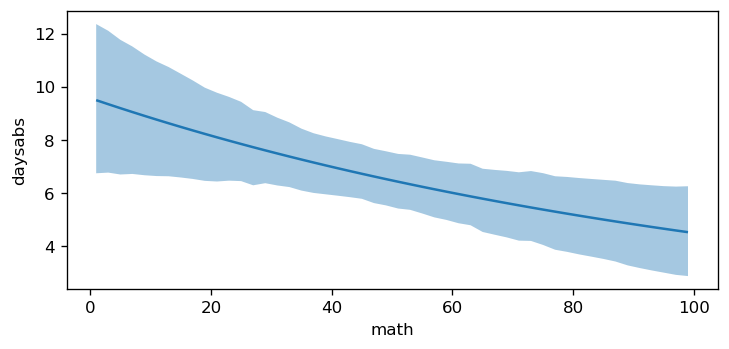

In [13]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(
    model_interaction, 
    idata_interaction, 
    "math", 
    ax=ax, 
    pps=False
);

The plot above shows that as `math` increases, the mean `daysabs` decreases. However, as the model contains an interaction term, the effect of `math` on `daysabs` depends on the value of `prog`. Therefore, we will use `plot_predictions` to plot the conditional adjusted predictions for each level of `prog`.

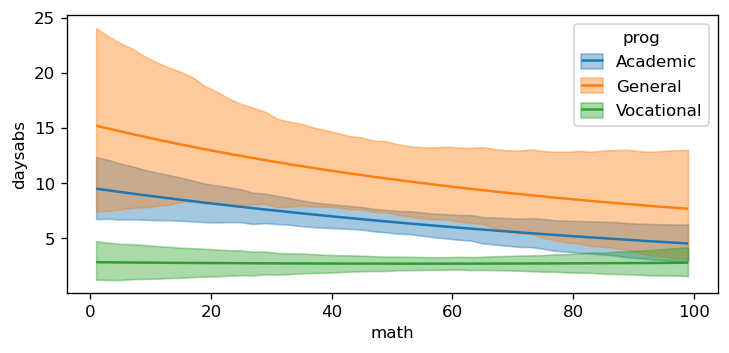

In [14]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(
    model_interaction, 
    idata_interaction, 
    ["math", "prog"], 
    ax=ax, 
    pps=False
);

Passing specific `subplot_kwargs` can allow for a more interpretable plot. Especially when the posterior predictive distribution plot results in overlapping credible intervals.

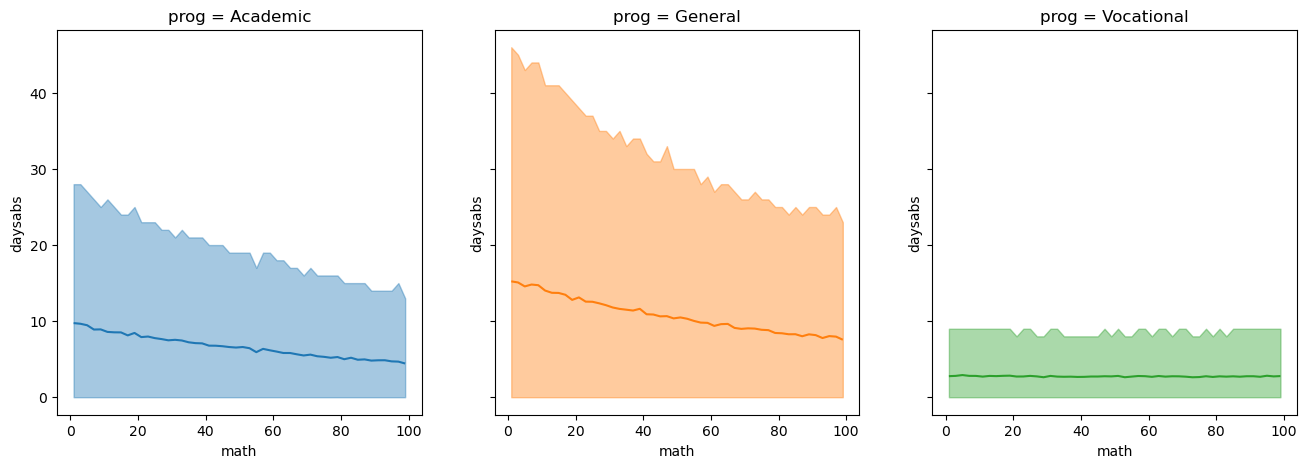

In [15]:
bmb.interpret.plot_predictions(
    model_interaction, 
    idata_interaction, 
    conditional=["math", "prog"],
    pps=True,
    subplot_kwargs={"main": "math", "group": "prog", "panel": "prog"},
    legend=False,
    fig_kwargs={"figsize": (16, 5), "sharey": True}
);

## Logistic Regression

To further demonstrate the `plot_predictions` function, we will implement a logistic regression model. This example is taken from the marginaleffects `plot_predictions` [documentation](https://vincentarelbundock.github.io/marginaleffects/articles/predictions.html#prediction-type-or-scale). The internet movie database, http://imdb.com/, is a website devoted to collecting movie data supplied by studios and fans. It claims to be the biggest movie database on the web and is run by Amazon. The movies in this dataset were selected for inclusion if they had a known length and had been rated by at least one imdb user. The dataset below contains 28,819 rows and 24 columns. The variables of interest in the dataset are the following:
- title. Title of the movie.
- year. Year of release.
- budget. Total budget (if known) in US dollars
- length. Length in minutes.
- rating. Average IMDB user rating.
- votes. Number of IMDB users who rated this movie.
- r1-10. Multiplying by ten gives percentile (to nearest 10%) of users who rated this movie a 1.
- mpaa. MPAA rating.
- action, animation, comedy, drama, documentary, romance, short. Binary variables represent- ing if movie was classified as belonging to that genre.

In [ ]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2movies/movies.csv")

data["style"] = "Other"
data.loc[data["Action"] == 1, "style"] = "Action"
data.loc[data["Comedy"] == 1, "style"] = "Comedy"
data.loc[data["Drama"] == 1, "style"] = "Drama"
data["certified_fresh"] = (data["rating"] >= 8) * 1
data = data[data["length"] < 240]

priors = {"style": bmb.Prior("Normal", mu=0, sigma=2)}
model = bmb.Model("certified_fresh ~ 0 + length * style", data=data, priors=priors, family="bernoulli")
idata = model.fit(random_seed=1234, target_accept=0.9, init="adapt_diag")

The logistic regression model uses a logit link function and a Bernoulli likelihood. Therefore, the link scale is the log-odds of a successful response and the response scale is the probability of a successful response.

In [13]:
model

       Formula: certified_fresh ~ 0 + length * style
        Family: bernoulli
          Link: p = logit
  Observations: 58662
        Priors: 
    target = p
        Common-level effects
            length ~ Normal(mu: 0.0, sigma: 0.0708)
            style ~ Normal(mu: 0.0, sigma: 2.0)
            length:style ~ Normal(mu: [0. 0. 0.], sigma: [0.0702 0.0509 0.0611])
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Again, by default, the `plot_predictions` function plots the mean outcome on the response scale. Therefore, the plot below shows the probability of a successful response `certified_fresh` as a function of `length`.

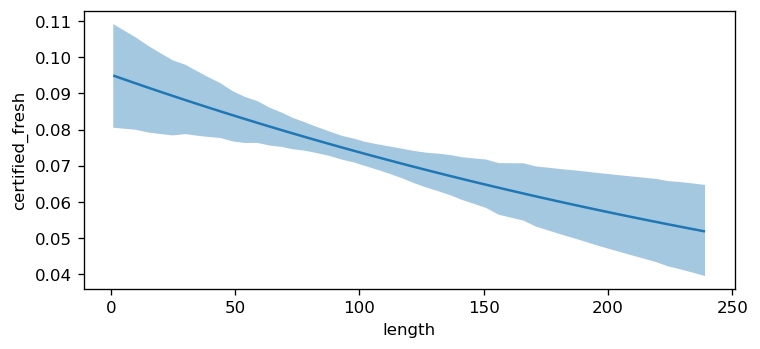

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, "length", ax=ax);

Additionally, we can see how the probability of `certified_fresh` varies as a function of categorical covariates. 

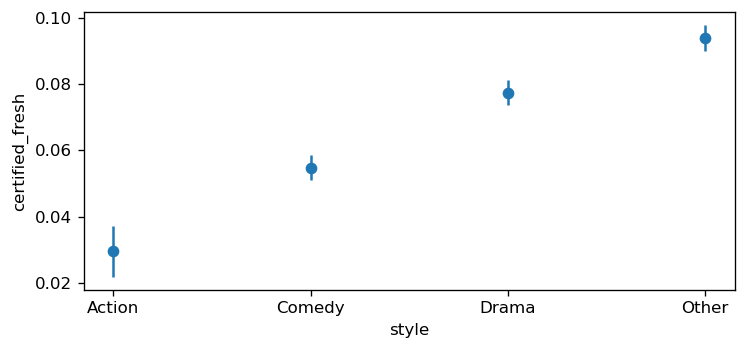

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, "style", ax=ax);

## Plotting other model parameters

`plot_predictions` also has the argument `target` where `target` determines what parameter of the response distribution is plotted as a function of the explanatory variables. This argument is useful in distributional models, i.e., when the response distribution contains a parameter for location, scale and or shape. The default of this argument is `mean` and passing a parameter into `target` only works when the argument `pps=False` because when `pps=True` the posterior predictive distribution is plotted and thus, can only refer to the outcome variable (instead of any of the parameters of the response distribution). For this example, we will simulate our own dataset.

In [ ]:
rng = np.random.default_rng(121195)
N = 200
a, b = 0.5, 1.1
x = rng.uniform(-1.5, 1.5, N)
shape = np.exp(0.3 + x * 0.5 + rng.normal(scale=0.1, size=N))
y = rng.gamma(shape, np.exp(a + b * x) / shape, N)
data_gamma = pd.DataFrame({"x": x, "y": y})

formula = bmb.Formula("y ~ x", "alpha ~ x")
model = bmb.Model(formula, data_gamma, family="gamma")
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, alpha_Intercept, alpha_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
model

       Formula: y ~ x
                alpha ~ x
        Family: gamma
          Link: mu = inverse
                alpha = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
    target = alpha
        Common-level effects
            alpha_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            alpha_x ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

The model we defined uses a `gamma` distribution parameterized by `alpha` and `mu` where `alpha` utilizes a log link and `mu` goes through an inverse link. Therefore, we can plot either: (1) the `mu` of the response distribution (which is the default), or (2) `alpha` of the response distribution as a function of the explanatory variable $x$. 

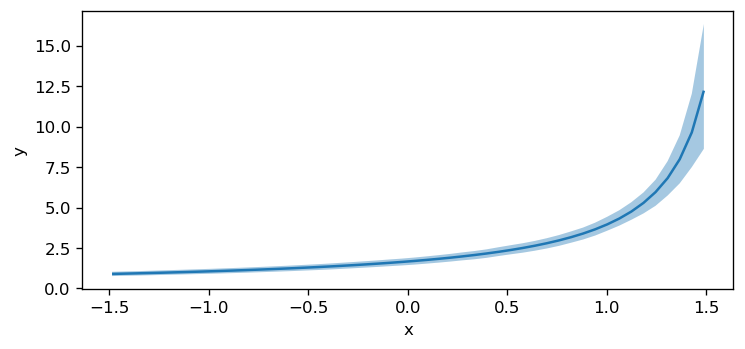

In [ ]:
# First, the mean of the response (default)
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, "x", ax=ax);

Below, instead of plotting the default target, `target=mean`, we set `target=alpha` to visualize how the model parameter `alpha` varies as a function of the `x` predictor.

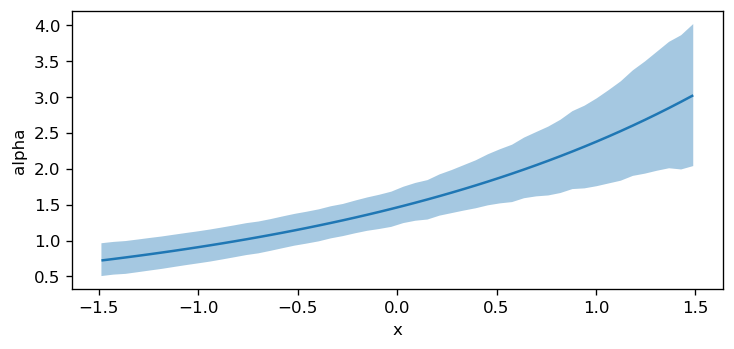

In [ ]:
# Second, another param. of the distribution: alpha
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
bmb.interpret.plot_predictions(model, idata, "x", target='alpha', ax=ax);

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Nov 06 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.13.2

bambi     : 0.13.0.dev0
pandas    : 2.1.0
numpy     : 1.24.2
matplotlib: 3.7.1

Watermark: 2.3.1

